# Data 620: Week 10 Assignment

Baron Curtin, Heather Geiger

## Introduction
It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

In [122]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# additional jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

Our dataset was taken from [Kaggle - SMS Spam Collection](https://www.kaggle.com/uciml/sms-spam-collection-dataset/download).
It is called the SMS Spam Collection dataset and it consists of 5,574 English SMS message that have been labelled "spam" or "ham".
The file contains one message per line. Each line is composed of two columns: the label, raw text.

## Data Loading
First we will load our data to begin building our Machine Learning Classifier.

In [2]:
data = pd.read_csv('./spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The last three columns are not useful to us and can safely be dropped

In [3]:
data = data.iloc[:,:2]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis
We will do some basic exploratory analysis to understand our data a bit better

Text(0.5, 0, 'Label')

Text(0.5, 1.0, 'Spam vs Ham Messages')

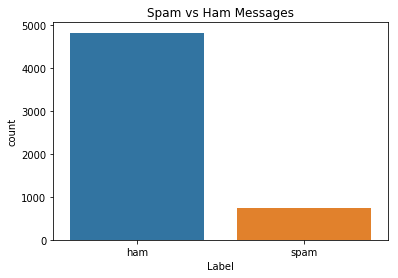

In [4]:
sns.countplot(data.v1)
plt.xlabel('Label')
plt.title('Spam vs Ham Messages')

ham     0.865937
spam    0.134063
Name: v1, dtype: float64

Text(0.5, 1.0, 'Spam vs Ham Messages 5')

Text(0.5, 0, 'Label')

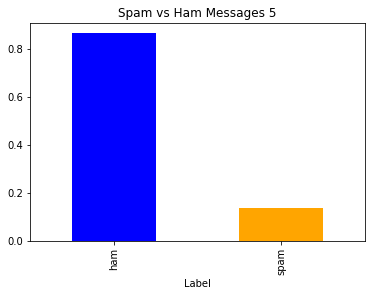

In [5]:
data.v1.value_counts(normalize=True)

data.v1.value_counts(normalize=True).plot(kind='bar', color=['blue','orange'])
plt.title('Spam vs Ham Messages')
plt.xlabel('Label')

We can see that spam messages comprise only ~13% of the dataset and ~87% represent "ham" messages. We can continue our
exploration by analyzing the frequency of words in each dataset

In [5]:
def join_n_split(my_df, msg_type):
    # filter dataframe based on msg type
    filtered_msgs = my_df[my_df['v1'] == msg_type]
    series = filtered_msgs['v2']
    # lowercase first then join together
    lcase = series.str.lower()
    return lcase.str.cat(sep=' ').split()

count_ham = Counter(join_n_split(data, 'ham'))
count_spam = Counter(join_n_split(data, 'spam'))

df_ham = pd.DataFrame.from_dict(count_ham, orient='index').reset_index()
df_ham.columns = ['word', 'ct']
df_ham['type'] = 'ham'

df_spam = pd.DataFrame.from_dict(count_spam, orient='index').reset_index()
df_spam.columns = ['word', 'ct']
df_spam['type'] = 'spam'

# union the dataframes
df = pd.concat([df_ham, df_spam], ignore_index=True).sort_values('ct', ascending=False)
df.head()


,word,ct,type
36,i,2172,ham
105,you,1665,ham
41,to,1544,ham
101,the,1113,ham
117,a,1046,ham


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


[Text(0, 0, 'i'),
 Text(1, 0, 'you'),
 Text(2, 0, 'to'),
 Text(3, 0, 'the'),
 Text(4, 0, 'a'),
 Text(5, 0, 'u'),
 Text(6, 0, 'and'),
 Text(7, 0, 'in'),
 Text(8, 0, 'my'),
 Text(9, 0, 'is')]

[Text(0, 0, 'to'),
 Text(1, 0, 'a'),
 Text(2, 0, 'call'),
 Text(3, 0, 'your'),
 Text(4, 0, 'you'),
 Text(5, 0, 'the'),
 Text(6, 0, 'for'),
 Text(7, 0, 'or'),
 Text(8, 0, 'free'),
 Text(9, 0, '2')]

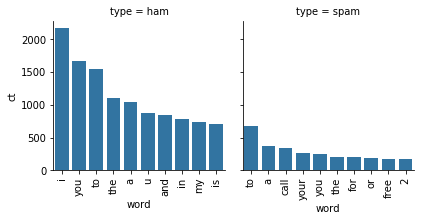

In [6]:
def get_top_x(my_df, x, msg_type):
    df_ = my_df[my_df['type'] == msg_type]
    return df_.sort_values('ct', ascending=False).head(x)

top_10_ham = get_top_x(df, 10, 'ham')
top_10_spam = get_top_x(df, 10, 'spam')

cond_plot = sns.FacetGrid(data=pd.concat([top_10_ham, top_10_spam], ignore_index=True), col='type', sharex=False)
cond_plot.map(sns.barplot, 'word', 'ct')
for ax in cond_plot.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


From the above, we can see that the top 10 most common words amongst both classes are stop words. We can use sklearn's built-in
stop words feature to remove those from our features, but we can get a preview of what our data looks like without the stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hmgeiger/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[Text(0, 0, 'u'),
 Text(1, 0, "i'm"),
 Text(2, 0, 'get'),
 Text(3, 0, '2'),
 Text(4, 0, '&lt;#&gt;'),
 Text(5, 0, 'ur'),
 Text(6, 0, 'go'),
 Text(7, 0, 'got'),
 Text(8, 0, '.'),
 Text(9, 0, 'like'),
 Text(10, 0, 'come'),
 Text(11, 0, 'call'),
 Text(12, 0, 'know'),
 Text(13, 0, 'good'),
 Text(14, 0, '?'),
 Text(15, 0, "i'll"),
 Text(16, 0, '...'),
 Text(17, 0, 'going'),
 Text(18, 0, '4'),
 Text(19, 0, 'ok')]

[Text(0, 0, 'call'),
 Text(1, 0, 'free'),
 Text(2, 0, '2'),
 Text(3, 0, 'ur'),
 Text(4, 0, 'txt'),
 Text(5, 0, 'u'),
 Text(6, 0, 'text'),
 Text(7, 0, 'mobile'),
 Text(8, 0, 'claim'),
 Text(9, 0, 'reply'),
 Text(10, 0, '&'),
 Text(11, 0, '4'),
 Text(12, 0, 'stop'),
 Text(13, 0, 'get'),
 Text(14, 0, 'now!'),
 Text(15, 0, 'new'),
 Text(16, 0, 'send'),
 Text(17, 0, 'nokia'),
 Text(18, 0, 'prize'),
 Text(19, 0, 'win')]

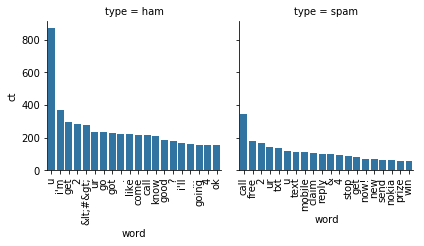

In [7]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# remove stop words
def remove_stopwords(my_df, col):
    df_ = my_df[~my_df[col].isin(stop_words)]
    return df_

no_stop_words = remove_stopwords(df, 'word')

# create visualizations
top_20_ham = get_top_x(no_stop_words, 20, 'ham')
top_20_spam = get_top_x(no_stop_words, 20, 'spam')

cond_plot = sns.FacetGrid(data=pd.concat([top_20_ham, top_20_spam], ignore_index=True), col='type', sharex=False)
cond_plot.map(sns.barplot, 'word', 'ct')
for ax in cond_plot.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

From the above charts, there is a clear distinction between what is usually found in a spam message as opposed to a ham message.
This will be captured in our models.


## Feature Engineering/Pipeline
In the next few steps, we will be using sklearn's pipeline feature to create our features, remove stop words, and fit the data
to our model. We intend to use multiple models to see which performs best.

Start by separating the text from the labels, and also create a 70/30 training test split.

Also convert the labels to a Numpy array.

In [171]:
X = pd.Series.tolist(data.v2)
y = pd.Series.tolist(data.v1)

x_and_y = [(x,y) for x,y in zip(X,y)]

random.seed(1392)
random.shuffle(x_and_y)

y_train = [y for x,y in x_and_y[0:3900]]
y_test = [y for x,y in x_and_y[3900:]]

In [172]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

Get text frequencies for the training and test data.

In [173]:
count_vect = CountVectorizer(stop_words='english')
tfidf_transformer = TfidfTransformer()

In [174]:
X_counts = count_vect.fit_transform([x for x,y in x_and_y])
X_tfidf = tfidf_transformer.fit_transform(X_counts)

X_tfidf_train = X_tfidf[0:3900,]
X_tfidf_test = X_tfidf[3900:,]

Train a naive Bayes model using the training data.

In [175]:
clf = MultinomialNB().fit(X_tfidf_train,y_train.ravel())

Get accuracy within the training data and on the test data.

In [176]:
predicted_train = clf.predict(X_tfidf_train)
predicted_test = clf.predict(X_tfidf_test)

In [178]:
def flatten_nested(l):
    return [item for sublist in np.ndarray.tolist(l.reshape(-1,1)) for item in sublist]

[x == y for x,y in zip(flatten_nested(predicted_train),flatten_nested(y_train))].count(True)/len(y_train)
[x == y for x,y in zip(flatten_nested(predicted_test),flatten_nested(y_test))].count(True)/len(y_test)

0.9784615384615385

0.9700956937799043

Accuracy is already quite good! 98% on the training data, 97% on the test data.

Let's just see if we can improve even more, though.

We'll try using a linear support vector machine (SVM) instead of a naive Bayes model.

Parameters loss, penalty, and alpha are set to defaults here.

Random state just sets the seed.

Set tol to None to require going through all iterations.

In [179]:
svm_classifier = SGDClassifier(loss='hinge',penalty='l2',alpha=0.0001,random_state=1392,tol=None)

In [181]:
clf = svm_classifier.fit(X_tfidf_train,y_train)

In [182]:
predicted_train = clf.predict(X_tfidf_train)
predicted_test = clf.predict(X_tfidf_test)

In [183]:
[x == y for x,y in zip(flatten_nested(predicted_train),flatten_nested(y_train))].count(True)/len(y_train)
[x == y for x,y in zip(flatten_nested(predicted_test),flatten_nested(y_test))].count(True)/len(y_test)

0.9994871794871795

0.9814593301435407

Accuracy using linear SVM is even better! 99.9% on the training data and 98% on the test data.

Let's print the confusion matrix for the test data.

In [184]:
confusion_matrix(y_true = y_test,y_pred = predicted_test,labels=[0,1])

array([[1451,    4],
       [  27,  190]])

Looks like the majority of errors are false negatives (letting spam past the filter by mis-classifying it as "ham") rather than false positives (putting real "ham" messages into the junk folder).

I would say this tradeoff of higher specificity at the cost of lower sensitivity is exactly what you want for a junk mail filter. If some spam makes it through the filter, they can always just delete it. Whereas if you put an important real message in the junk mail folder, that can really cause problems for the user.